# **TBRC Model Training**
Author: Michael Kainola

Date: August 1, 2022

This notebook demonstrates the key steps for training the TBRC temperature prediction LSTM model.

Notes:
* I learned how to perform multivariate time series forecasting using the following resource: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/. Many of the model parameters and settings are based on this article. For instance, the use of the MinMaxScaler scaler and Relu for model activation. Future research could include investigation into alternatives.

<br>

**Step 1. Load the external dependencies.**

In [1]:
# import standard modules
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt

# keras modules for creating and training LSTM Model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

from sklearn.preprocessing import MinMaxScaler # for scaling the data

# for calculating root mean square error (RMSE) of the model
from sklearn.metrics import mean_squared_error 
from math import sqrt

from pickle import dump # from saving the scaler to file

<br>

**Step 2. Load the training and test data.**

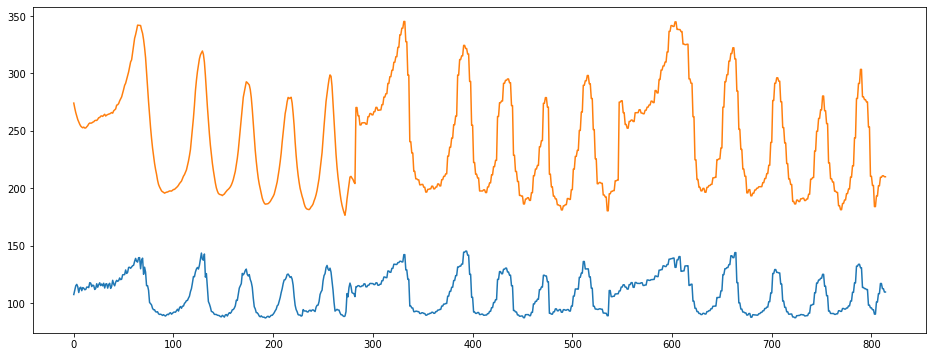

In [2]:
# read the training / test dataset; this dataset was prepared by appending three of the simulated training datasets
df = pd.read_csv('Inputs/simulated_data.csv', usecols=["Brightness", "Temperature"]) #specify colums to read

bright = df["Brightness"] # store brightness data
temp = df["Temperature"] # store temp data

# show the data
plt.figure(figsize=(16, 6))
plt.plot(bright) # in blue
plt.plot(temp) # in orange
plt.show()

<br>

**Step 3. Scale the data.**

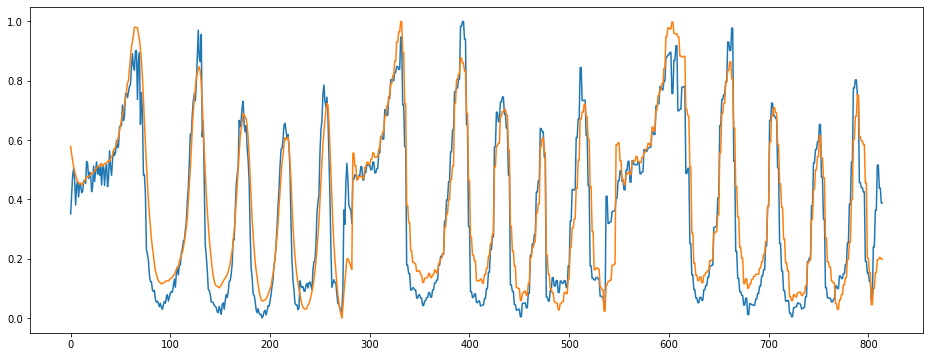

In [3]:
#scale the data to ensure temperature / luminosity have proportionate influence over the model training
scaler = MinMaxScaler()
scaler = scaler.fit(df)
scaled_df = scaler.transform(df)

# save the scaler for later use in performing predictions
dump(scaler, open('scaler.pkl', 'wb'))

#create lists for each metric
scaled_bright = [d[0] for d in scaled_df]
scaled_temp = [d[1] for d in scaled_df]

#convert lists back to numpy array
scaled_bright = np.array(scaled_bright)
scaled_temp = np.array(scaled_temp)

# show the scaled data
plt.figure(figsize=(16, 6))
plt.plot(scaled_bright)
plt.plot(scaled_temp)
plt.show()

<br>

**Step 4. Reshape the data to a format that keras can work with.**

In [4]:
# reshape the data to a format that keras can work with
scaled_bright = scaled_bright.reshape((len(bright), 1))
scaled_temp = scaled_temp.reshape((len(temp), 1))

# horizontally stack the columns
dataset = hstack((scaled_bright, scaled_temp))

# split the test and train data
ds_split = int(len(dataset) *.8)
train_dataset = dataset[:ds_split] # first 80% for train
test_dataset = dataset[ds_split:] # remaining 20% for test

<br>

**Step 5. Define the generator.**

In [5]:
# define features and number of inputs
n_features = dataset.shape[1] #number of features - temp and brightness
n_input = 20 #number of inputs into the generator

# create separate generators for train and test
generator_train = TimeseriesGenerator(train_dataset, train_dataset, length=n_input, batch_size=8)
generator_test = TimeseriesGenerator(test_dataset, test_dataset, length=n_input, batch_size=8)

<br>

**Step 6. Define and train the model.**

In [6]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

# train the model
model.fit_generator(
    generator = generator_train, 
    steps_per_epoch = 10, 
    epochs = 100, 
    verbose = 1, # 0 - silent; 1 - progress bar
    validation_data = generator_test
) 

C:\Users\Mike\OneDrive\Desktop\Final_Code\env_submit\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 57s 317ms/step - loss: 0.1551 - val_loss: 0.0670
Epoch 2/100
10/10 [==============================] - 0s 36ms/step - loss: 0.0568 - val_loss: 0.0387
Epoch 3/100
10/10 [==============================] - 0s 45ms/step - loss: 0.0734 - val_loss: 0.0830
Epoch 4/100
10/10 [==============================] - 0s 36ms/step - loss: 0.1300 - val_loss: 0.0324
Epoch 5/100
10/10 [==============================] - 0s 39ms/step - loss: 0.0282 - val_loss: 0.0346
Epoch 6/100
10/10 [==============================] - 0s 35ms/step - loss: 0.0310 - val_loss: 0.0294
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0393 - val_loss: 0.0296
Epoch 8/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0227 - val_loss: 0.0306
Epoch 9/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0427 - val_loss: 0.0278
Epoch 10/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0294 - val_loss: 0.02

<br>

**Step 7. Visualize loss over training epochs.**

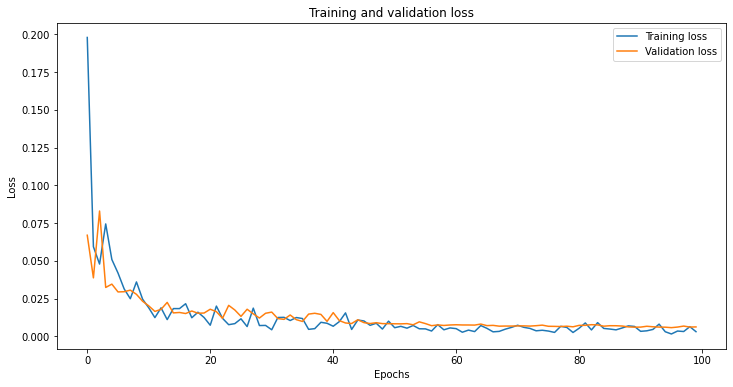

In [7]:
# visualize loss over training epochs
plt.figure(figsize=(12, 6))
plt.plot(model.history.history['loss'], label='Training loss')
plt.plot(model.history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<br>

**Step 8. Test Predictions.**

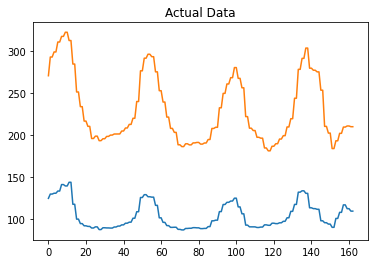

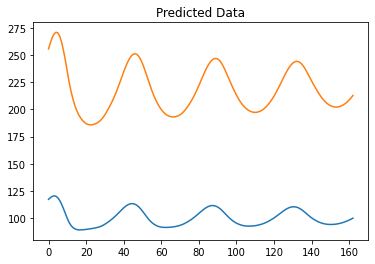

In [8]:
# test and visualize the efficacy of the model
test_predictions = []

# last 20 records of training dataset
first_eval_batch = train_dataset[-n_input:] 
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# loop through the test dataset
for i in range(len(test_dataset)):
    
    # get the prediction value
    current_pred = model.predict(current_batch)[0]
        
    # append the prediction into the array
    test_predictions.append(current_pred)
    
    # use the prediction to update the batch; remove the first value from the batch
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
# perform inverse scaling to get the actual prediction
true_predictions = scaler.inverse_transform(test_predictions)
true_production = scaler.inverse_transform(test_dataset)

# show the actual and predicted data
plt.plot(true_production)
plt.title("Actual Data")
plt.show()
plt.plot(true_predictions)
plt.title("Predicted Data")
plt.show()

<br>

**Step 9. Calculate Root Mean Square Error (RMSE).**

In [10]:
# calculate RMSE of the predictions
rmse=sqrt(mean_squared_error(true_production,true_predictions))

# print the RMSE - best model was around 12 RMSE
print(rmse)

28.829301844411305
